In [38]:
import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Get stock data from Yahoo Finance
def get_stock_prices(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    return df


def create_stock_price_graph(df):
    """
    Function for creating a graph of price changes.
    Vertices: dates;
    Edges: connections between consecutive dates;
    Weights: price difference between the corresponding dates.
    """
    G = nx.Graph()
    for i in range(1, len(df)):
        G.add_edge(df.index[i-1], df.index[i], weight=abs(df["Close"].iloc[i] - df["Close"].iloc[i-1]))
    return G

In [3]:
# Set the stock symbol and the time interval for data retrieval
symbol = "BAC" # Bank of America
start_date = "2023-01-01"
end_date = "2024-03-01"

df = get_stock_prices(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


- **Date**: The date of the trading session;
- **Open**: The opening price of the stock at the beginning of the trading session;
- **High**: The highest price of the stock during the trading session;
- **Low**: The lowest price of the stock during the trading session;
- **Close**: The closing price of the stock at the end of the trading session;
- **Adj Close**: The adjusted closing price of the stock (accounts for additional factors such as dividends, stock splits, etc.);
- **Volume**: The trading volume of the stock for the trading session.


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,33.230000,34.090000,33.209999,33.509998,32.270802,35221500
2023-01-04,33.900002,34.820000,33.830002,34.139999,32.877502,41998500
2023-01-05,33.919998,34.139999,33.580002,34.070000,32.810093,34177000
2023-01-06,34.090000,34.580002,33.540001,34.410000,33.137520,34068700
2023-01-09,34.750000,34.759998,33.709999,33.889999,32.636749,43818800
...,...,...,...,...,...,...
2024-02-23,33.730000,34.049999,33.490002,33.919998,33.682728,30586000
2024-02-26,33.790001,34.220001,33.529999,33.610001,33.374897,31129200
2024-02-27,33.730000,34.430000,33.709999,34.279999,34.040211,40536300


In [5]:
df.shape

(291, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291 entries, 2023-01-03 to 2024-02-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       291 non-null    float64
 1   High       291 non-null    float64
 2   Low        291 non-null    float64
 3   Close      291 non-null    float64
 4   Adj Close  291 non-null    float64
 5   Volume     291 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 15.9 KB


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,291.000000,291.000000,291.000000,291.000000,291.000000,2.910000e+02
mean,30.506254,30.841478,30.186564,30.530447,29.875383,4.724724e+07
std,2.780649,2.816048,2.798550,2.846453,2.781064,2.262702e+07
min,25.320000,25.650000,24.959999,25.170000,24.796028,1.581560e+07
25%,28.379999,28.650000,28.000000,28.335000,27.614389,3.423850e+07
50%,29.570000,29.870001,29.250000,29.540001,28.951979,4.168310e+07
75%,33.289999,33.669998,32.920000,33.430000,32.877502,5.168025e+07
max,36.410000,37.000000,36.340000,36.770000,35.410252,2.184033e+08


In [ ]:
desc = df.describe().round(2)
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=desc.values,
                 colLabels=desc.columns,
                 rowLabels=desc.index,
                 cellLoc="center",
                 loc="center",
                 colColours=["lightgray"]*len(desc.columns))

plt.savefig("describe.png", bbox_inches="tight")
#plt.show()

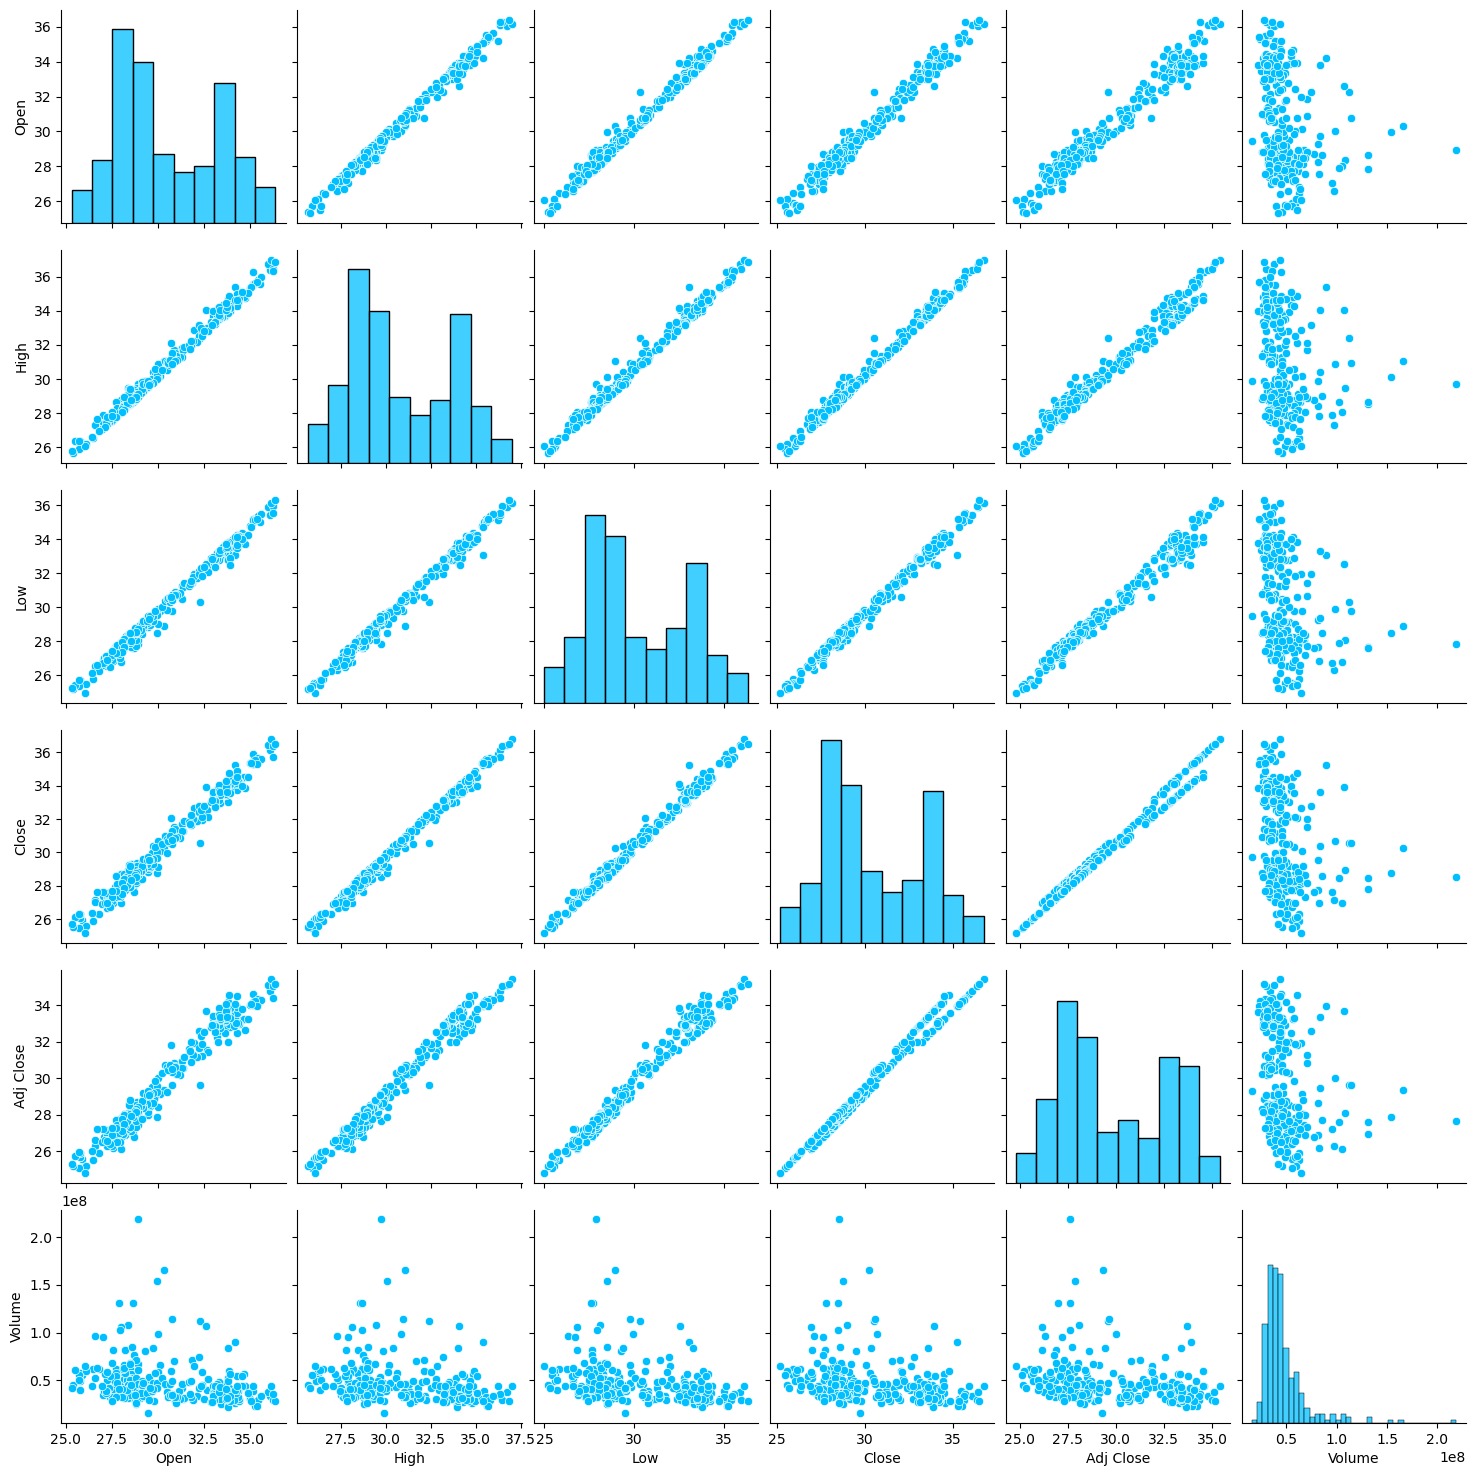

In [8]:
sns.pairplot(df, diag_kws={"color": "deepskyblue"}, plot_kws={"color": "deepskyblue"})

<Axes: ylabel='Date'>

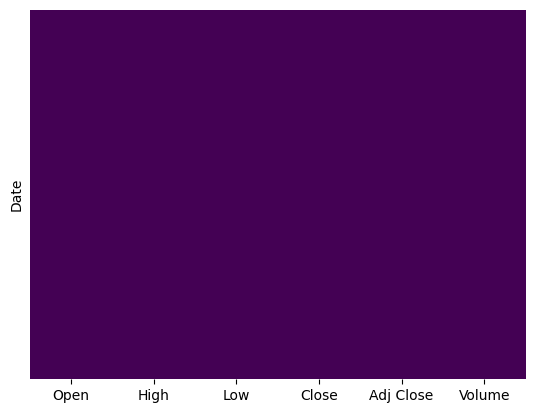

In [9]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

There are no missing values in the dataset

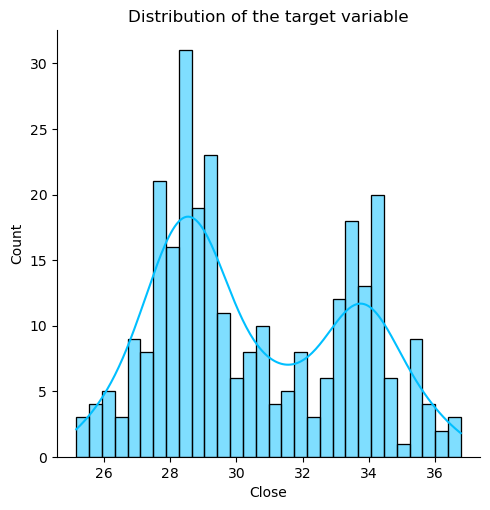

In [52]:
sns_plot = sns.displot(df["Close"], bins=30, kde=True, color="deepskyblue")
sns_plot.set(title="Distribution of the target variable")
#sns_plot.savefig("target_dist.png")

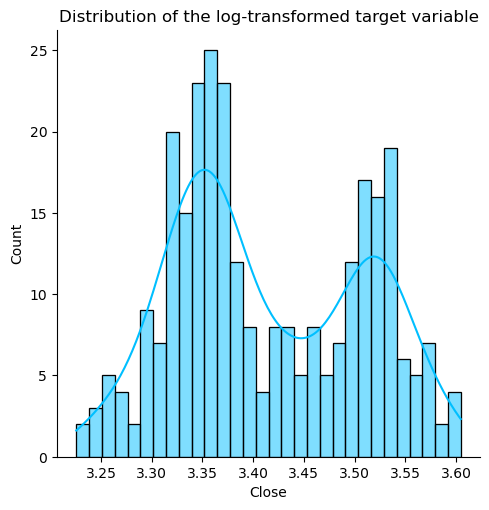

In [53]:
sns_plot = sns.displot(np.log(df["Close"]), bins=30, kde=True, color="deepskyblue")
sns_plot.set(title="Distribution of the log-transformed target variable")
#sns_plot.savefig("log_target_dist.png")

In [12]:
def print_graph_statistics(G):
    """
    Function to print the statistics of a graph.
    """
    print("\nGraph Statistics:")
    print(50*"-")
    print("Number of vertices:", G.number_of_nodes())
    print("Number of edges:", G.number_of_edges())
    print("Average degree:", np.mean([d for n, d in G.degree()]))
    print("Density:", nx.density(G))
    print("Average clustering coefficient:", nx.average_clustering(G))
    print("Diameter:", nx.diameter(G))
    print("Assortativity coefficient:", nx.degree_assortativity_coefficient(G))
    print("Transitivity:", nx.transitivity(G))
    print("Global efficiency:", nx.global_efficiency(G))
    print("Average shortest path length:", nx.average_shortest_path_length(G))
    print("Number of connected components:", nx.number_connected_components(G))
    print("Size of largest connected component:", len(max(nx.connected_components(G), key=len)))
    print("Degree Centrality:", sum(nx.degree_centrality(G).values()))
    print("Closeness Centrality:", sum(nx.closeness_centrality(G).values()))
    print("Betweenness Centrality:", sum(nx.betweenness_centrality(G).values()))

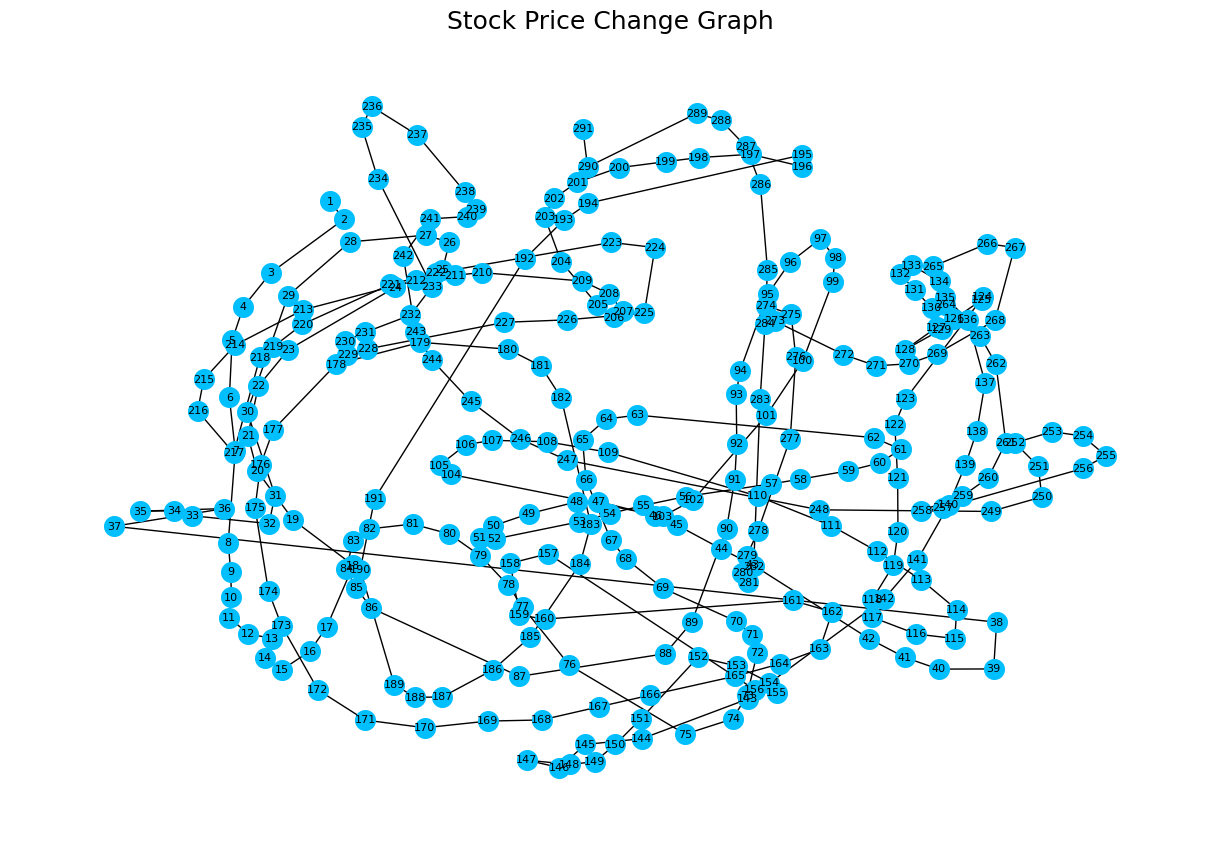

Vertex - Date Mapping:
--------------------------------------------------
Node 1: 2023-01-03
Node 2: 2023-01-04
Node 3: 2023-01-05
Node 4: 2023-01-06
Node 5: 2023-01-09
Node 6: 2023-01-10
Node 7: 2023-01-11
Node 8: 2023-01-12
Node 9: 2023-01-13
Node 10: 2023-01-17
Node 11: 2023-01-18
Node 12: 2023-01-19
Node 13: 2023-01-20
Node 14: 2023-01-23
Node 15: 2023-01-24
Node 16: 2023-01-25
Node 17: 2023-01-26
Node 18: 2023-01-27
Node 19: 2023-01-30
Node 20: 2023-01-31
Node 21: 2023-02-01
Node 22: 2023-02-02
Node 23: 2023-02-03
Node 24: 2023-02-06
Node 25: 2023-02-07
Node 26: 2023-02-08
Node 27: 2023-02-09
Node 28: 2023-02-10
Node 29: 2023-02-13
Node 30: 2023-02-14
Node 31: 2023-02-15
Node 32: 2023-02-16
Node 33: 2023-02-17
Node 34: 2023-02-21
Node 35: 2023-02-22
Node 36: 2023-02-23
Node 37: 2023-02-24
Node 38: 2023-02-27
Node 39: 2023-02-28
Node 40: 2023-03-01
Node 41: 2023-03-02
Node 42: 2023-03-03
Node 43: 2023-03-06
Node 44: 2023-03-07
Node 45: 2023-03-08
Node 46: 2023-03-09
Node 47: 2023-0

In [54]:
stock_price_graph = create_stock_price_graph(df)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(stock_price_graph, seed=42)
nx.draw(stock_price_graph, pos, with_labels=False, node_size=200, node_color="deepskyblue")
node_labels = {n: i for i, n in enumerate(stock_price_graph.nodes(), 1)}
nx.draw_networkx_labels(stock_price_graph, pos, labels=node_labels, font_size=8, font_color="black")
plt.title("Stock Price Change Graph", fontsize=18)
#plt.savefig("graph.png")
plt.show()

print("Vertex - Date Mapping:")
print(50*"-")
for node, index in node_labels.items():
    print(f"Node {index}: {node.strftime('%Y-%m-%d')}")

print_graph_statistics(stock_price_graph)

- **Average degree**: the average degree of the vertices is approximately 1.99, indicating that, on average, each vertex is connected to about two other vertices;
- **Density**: the density of the graph is approximately 0.00687, suggesting that the graph is sparse, with relatively few edges compared to the maximum possible number of edges;
- **Average clustering coefficient**: the average clustering coefficient is 0.0, which suggests that there are no clusters present in the graph;
- **Diameter**: the diameter of the graph is 290, meaning that the maximum distance between any two vertices is 290 units;
- **Assortativity coefficient**: the assortativity coefficient is close to zero (-0.00346), indicating that there is no clear tendency for high-degree vertices to be connected to other high-degree vertices;
- **Transitivity**: the transitivity is 0, indicating the absence of transitivity (triangles) in the graph;
- **Global efficiency**: the global efficiency is 0.036, suggesting that information transmission through the graph is relatively inefficient;
- **Average shortest path length**: the average shortest path length is approximately 97.33 units, meaning that, on average, it takes around 97 edges to reach one vertex from another;
- **Number of connected components**: there is only 1 connected component in the graph, meaning that every vertex is reachable from every other vertex;
- **Size of largest connected component**: the largest connected component contains 291 vertices, indicating that all vertices in the graph belong to the same component;
- **Degree Centrality**: the average degree centrality of the vertices is approximately 2.0, indicating that, on average, each vertex is connected to about two other vertices;
- **Closeness Centrality**: the average closeness centrality is approximately 3.13, suggesting that the vertices are relatively close to each other in terms of the shortest path length;
- **Betweenness Centrality**: the average betweenness centrality is approximately 97.0, indicating that many of the shortest paths between vertices pass through these central vertices, suggesting their importance in the graph's structure.

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# Prepare data for GCN
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Close"]])
df_scaled = torch.tensor(df_scaled, dtype=torch.float)

In [16]:
data_list = []
for i in range(1, len(df)):
    data = Data(x=df_scaled[i-1:i+1], edge_index=torch.tensor([[0, 1], [1, 0]], dtype=torch.long))
    data_list.append(data)

In [17]:
train_data, test_data = train_test_split(data_list, test_size=0.2, shuffle=False)

train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [20]:
def train_gcn_with_early_stopping(model, train_loader, optimizer, criterion, device, patience=10):
    model.train()
    min_loss = float("inf")
    patience_counter = 0
    
    for epoch in range(200):
        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.x[1])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        # Check for early stopping
        if avg_loss < min_loss:
            min_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [21]:
# Train GCN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(1, 16, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_gcn_with_early_stopping(model, train_loader, optimizer, criterion, device, patience=10)

Epoch 1, Loss: 0.0443
Epoch 2, Loss: 0.0071
Epoch 3, Loss: 0.0064
Epoch 4, Loss: 0.0063
Epoch 5, Loss: 0.0061
Epoch 6, Loss: 0.0058
Epoch 7, Loss: 0.0056
Epoch 8, Loss: 0.0052
Epoch 9, Loss: 0.0048
Epoch 10, Loss: 0.0044
Epoch 11, Loss: 0.0040
Epoch 12, Loss: 0.0037
Epoch 13, Loss: 0.0035
Epoch 14, Loss: 0.0033
Epoch 15, Loss: 0.0031
Epoch 16, Loss: 0.0031
Epoch 17, Loss: 0.0031
Epoch 18, Loss: 0.0031
Epoch 19, Loss: 0.0032
Epoch 20, Loss: 0.0033
Epoch 21, Loss: 0.0033
Epoch 22, Loss: 0.0034
Epoch 23, Loss: 0.0034
Epoch 24, Loss: 0.0035
Epoch 25, Loss: 0.0035
Epoch 26, Loss: 0.0035
Epoch 27, Loss: 0.0035
Early stopping triggered


In [22]:
# Extract GCN features
model.eval()
gcn_features = []
with torch.no_grad():
    for data in train_loader:
        data = data.to(device)
        out = model(data)
        gcn_features.append(out.cpu().numpy())

gcn_features = np.array(gcn_features).reshape(-1, 1)

In [23]:
# Prepare data for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [24]:
seq_length = 5
X, y = create_sequences(gcn_features, seq_length)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [27]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
def train_lstm_with_early_stopping(model, train_loader, optimizer, criterion, device, patience=10):
    model.train()
    min_loss = float("inf")
    patience_counter = 0

    for epoch in range(100):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        # Check for early stopping
        if avg_loss < min_loss:
            min_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [32]:
# Train LSTM
input_size = 1
hidden_size = 16
num_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_lstm_with_early_stopping(model, train_loader, optimizer, criterion, device, patience=10)

Epoch 1, Loss: 0.0319
Epoch 2, Loss: 0.0167
Epoch 3, Loss: 0.0024
Epoch 4, Loss: 0.0014
Epoch 5, Loss: 0.0011
Epoch 6, Loss: 0.0010
Epoch 7, Loss: 0.0010
Epoch 8, Loss: 0.0012
Epoch 9, Loss: 0.0012
Epoch 10, Loss: 0.0012
Epoch 11, Loss: 0.0011
Epoch 12, Loss: 0.0009
Epoch 13, Loss: 0.0009
Epoch 14, Loss: 0.0009
Epoch 15, Loss: 0.0008
Epoch 16, Loss: 0.0008
Epoch 17, Loss: 0.0018
Epoch 18, Loss: 0.0017
Epoch 19, Loss: 0.0010
Epoch 20, Loss: 0.0007
Epoch 21, Loss: 0.0007
Epoch 22, Loss: 0.0008
Epoch 23, Loss: 0.0007
Epoch 24, Loss: 0.0010
Epoch 25, Loss: 0.0008
Epoch 26, Loss: 0.0007
Epoch 27, Loss: 0.0006
Epoch 28, Loss: 0.0006
Epoch 29, Loss: 0.0005
Epoch 30, Loss: 0.0005
Epoch 31, Loss: 0.0005
Epoch 32, Loss: 0.0005
Epoch 33, Loss: 0.0004
Epoch 34, Loss: 0.0004
Epoch 35, Loss: 0.0004
Epoch 36, Loss: 0.0003
Epoch 37, Loss: 0.0004
Epoch 38, Loss: 0.0005
Epoch 39, Loss: 0.0004
Epoch 40, Loss: 0.0003
Epoch 41, Loss: 0.0004
Epoch 42, Loss: 0.0003
Epoch 43, Loss: 0.0004
Epoch 44, Loss: 0.00

In [33]:
# Test LSTM
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        out = model(X_batch)
        predictions.append(out.cpu().numpy().flatten()) # Extracting predictions and converting them into a one-dimensional array

In [34]:
# Combining all predictions into one array
predictions = np.concatenate(predictions).reshape(-1, 1)

In [35]:
# Reverse scaling of predicted and true values
y_test_inv = scaler.inverse_transform(y_test.cpu())
predictions_inv = scaler.inverse_transform(predictions)

In [42]:
mse = mean_squared_error(y_test_inv, predictions_inv)
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.0258
MAE: 0.1226
R² Score: 0.9783


In [43]:
result_df = pd.DataFrame({"Actual": y_test_inv.flatten(), "Predicted": predictions_inv.flatten()})
result_df

,Actual,Predicted
0,28.751468,29.069250
1,28.751468,28.824814
2,28.268486,28.633186
3,28.268486,28.392784
4,28.018781,28.159103
...,...,...
87,31.172948,31.138708
88,31.281373,31.223885
89,31.281373,31.253645
90,31.156521,31.287867


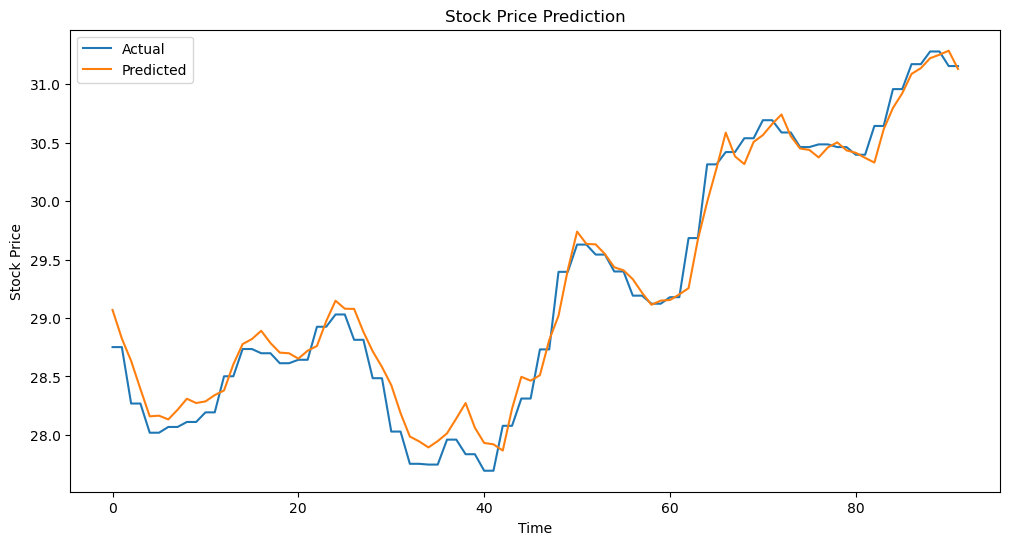

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual")
plt.plot(predictions_inv, label="Predicted")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction")
plt.legend()
plt.show()